In [ ]:
!pip install git+https://github.com/sean-mcclure/tetryon_ai.git

  Cloning https://github.com/sean-mcclure/tetryon_ai.git to /tmp/pip-req-build-9tugppli
  Running command git clone -q https://github.com/sean-mcclure/tetryon_ai.git /tmp/pip-req-build-9tugppli
  Created wheel for tetryonai: filename=tetryonai-0.1-py3-none-any.whl size=124682 sha256=302e217355eb8d1d8100bb09f080c459cb636bf1cdbc3c557ab67b8edd046c05
  Stored in directory: /tmp/pip-ephem-wheel-cache-2r6ou6x5/wheels/6e/09/32/8280334024f8c097e3d94a363210afcef97f631dcc9723dc4c
Successfully built tetryonai


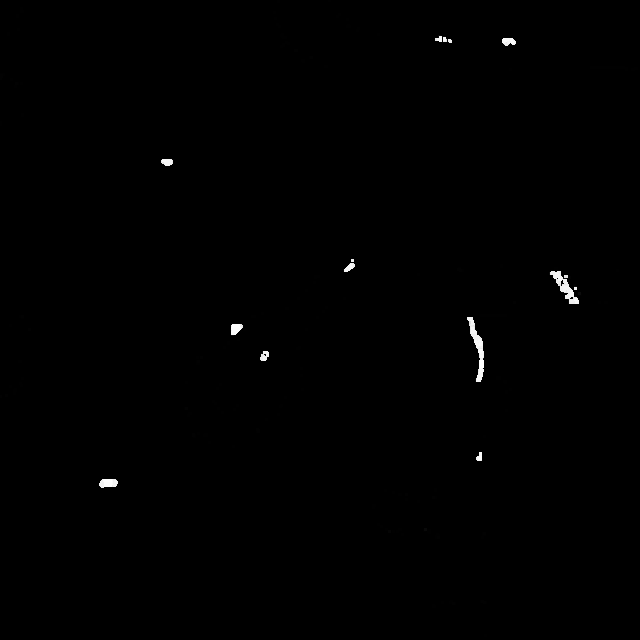

error: ignored

In [ ]:
import numpy as np
import cv2
from tetryonai.main import *
from google.colab.patches import cv2_imshow

im1 = cv2.imread("/content/drive/MyDrive/ENEE439D Project/00041000_temp.jpg")
im2 = cv2.imread("/content/drive/MyDrive/ENEE439D Project/00041000_test.jpg")

sub = cv2.bitwise_xor(im1, im2)

sub_filter = cv2.morphologyEx(sub, cv2.MORPH_OPEN, np.ones((3, 3)))

sub_uint8 = sub_filter.astype(np.uint8)



contours = cv2.findContours(sub_uint8, cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

#contours = cv2.drawContours(sub_filter, )

#cv2_imshow(im2)



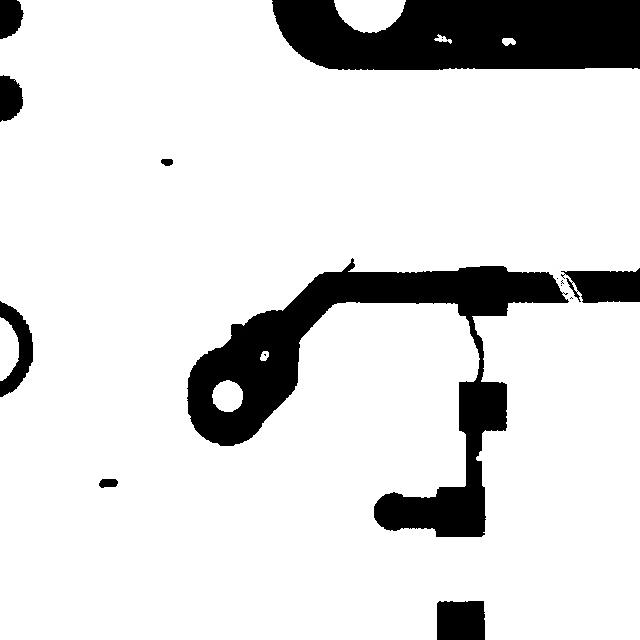

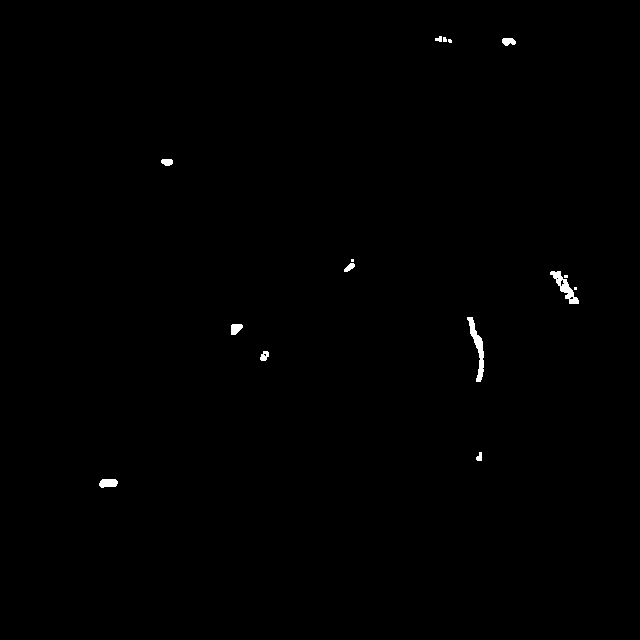

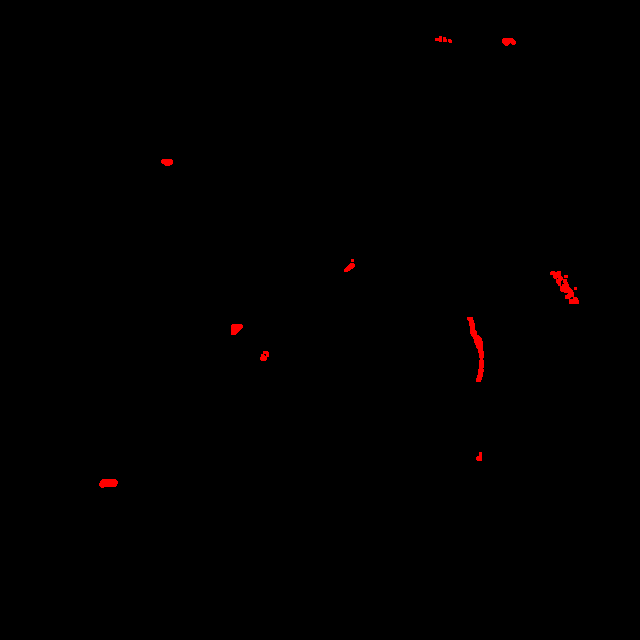

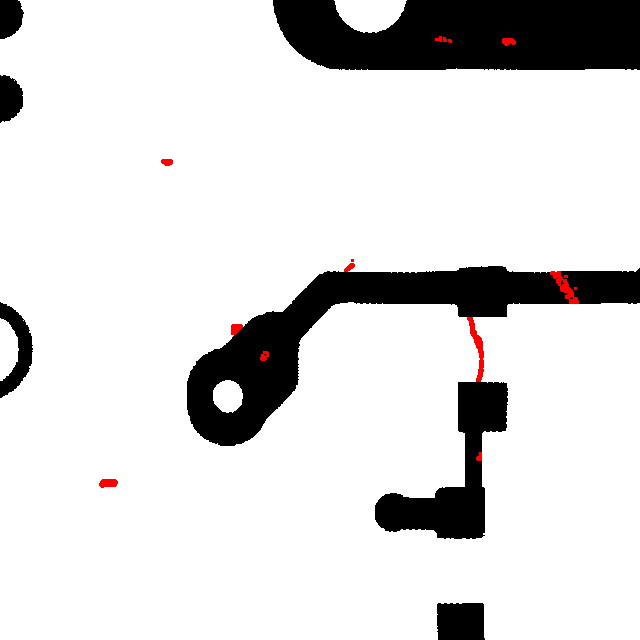

In [51]:
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow

im = cv.imread('/content/drive/MyDrive/ENEE439D Project/00041000_temp.jpg')
im2 = cv.imread('/content/drive/MyDrive/ENEE439D Project/00041000_test.jpg')

ref = im

sub = cv.bitwise_xor(im, im2)

sub_filter = cv.morphologyEx(sub, cv.MORPH_OPEN, np.ones((3, 3)))

_, sub_thresh = cv.threshold(sub_filter, 127, 255, cv.THRESH_BINARY)

black = cv.morphologyEx(sub_filter, cv.MORPH_ERODE, np.ones((9, 9)))

imgray = cv.cvtColor(sub_thresh, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(imgray, 127, 255, 0)

contours, hierarchy = cv.findContours(imgray, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(ref, contours, -1, (0, 0, 255), -1)
cv.drawContours(black, contours, -1, (0, 0, 255), -1)

cv2_imshow(im2)
print("")
cv2_imshow(sub_thresh)
print("")
cv2_imshow(black)
print("")
cv2_imshow(ref)

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>


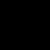

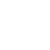

In [56]:
IMAGE_WIDTH = len(black[0])
IMAGE_HEIGHT = len(black)

WIDTH = 50
HEIGHT = 50

separated_contours = []
separated_contours_on_ref = []

for contour in contours:
  moment = cv.moments(contour)

  center_x = moment["m10"] / moment["m00"]
  center_y = moment["m01"] / moment["m00"]

  l_side_x = int(center_x - WIDTH // 2)
  r_side_x = int(center_x + WIDTH // 2)
  top_side_y = int(center_y - HEIGHT // 2)
  bottom_side_y = int(center_y + HEIGHT // 2)

  if l_side_x < 0:
    l_side_x = 0

  if r_side_x > IMAGE_WIDTH:
    r_side_x = IMAGE_WIDTH

  if top_side_y < 0:
    top_side_y = 0

  if bottom_side_y > IMAGE_HEIGHT:
    bottom_side_y = IMAGE_HEIGHT

  separated_contours.append(black[l_side_x:r_side_x, top_side_y:bottom_side_y])
  separated_contours_on_ref.append(ref[l_side_x:r_side_x, top_side_y:bottom_side_y])

cv2_imshow(separated_contours[0])
cv2_imshow(separated_contours_on_ref[0])